In [1]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.insert(0, '../../')
import DLDMD as dl
import LossDLDMD as lf
import Data as dat
import Training as tr

%matplotlib inline

In [2]:
def edmd(x, num_pred, t_final, delta_t):
    x = tf.transpose(x, perm=[0, 2, 1])
    x_m = x[:, :, :-1]
    x_p = x[:, :, 1:]
    S, U, V = tf.linalg.svd(x_m, compute_uv=True, full_matrices=False)
    sm = np.max(S)
    r = S.shape[-1]  # self.log10(S / sm) > -10
    Sri = tf.linalg.diag(1./S[:, :r])
    Ur = U[:, :, :r]
    Urh = tf.linalg.adjoint(Ur)
    Vr = V[:, :, :r]

    kmat = x_p @ Vr @ Sri @ Urh
    evals, evecs = tf.linalg.eig(kmat)
    phim = tf.linalg.solve(evecs, tf.cast(x_m, dtype=tf.complex128))
    x0 = phim[:, :, -1]
    x0 = x0[:, :, tf.newaxis]

    pred = tf.TensorArray(tf.complex128, size=num_pred)
    pred = pred.write(0, evecs @ x0)
    evals_iter = evals
    for ii in range(1, num_pred):
        tmp = evecs @ tf.linalg.diag(evals_iter) @ x0
        pred = pred.write(ii, tmp)
        evals_iter = evals_iter * evals
    pred = tf.transpose(tf.squeeze(pred.stack()), perm=[1, 2, 0])
    return pred, phim, evals, evecs

# Setup

In [3]:
# Figure parameters
plot_save_path = './analysis_results/'
font = {'family': 'DejaVu Sans', 'size': 18}
matplotlib.rc('font', **font)
fontsize = 18
figsize = (15, 10)
dpisave = 300

# Initialize the compute device
# DEVICE = '/GPU:0'
GPUS = tf.config.experimental.list_physical_devices('GPU')
# if GPUS:
#     try:
#         for gpu in GPUS:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)
# else:
#     DEVICE = '/CPU:0'
DEVICE = '/CPU:0'
    
tf.keras.backend.set_floatx('float64')  # !! Set precision for the entire model here
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Num GPUs available: {}".format(len(GPUS)))
print("Training at precision: {}".format(tf.keras.backend.floatx()))
print("Training on device: {}".format(DEVICE))

TensorFlow version: 2.5.0
Eager execution: True
Num GPUs available: 2
Training at precision: float64
Training on device: /CPU:0


# Load model and data

In [4]:
# SET THIS PATH (w/o file extension). Both '.pkl' and '.h5' files should have same name
# model_path = './trained_models/pendulum_2021-06-08-2132/epoch_100_loss_-2.68'
model_path = './trained_models/pendulum_2021-09-07-1846/epoch_900_loss_-3.96'
hyp_params_path = model_path + '.pkl'
weight_path = model_path + '.h5'

# Load the hyper parameters
hyp_params = pickle.load(open(hyp_params_path, 'rb'))

# Set Tensorflow backend precision
tf.keras.backend.set_floatx(hyp_params['precision'])
print("Using precision: {}\n".format(tf.keras.backend.floatx()))

# Load evenly spaced rings for test trajectories (from Lusch et al 2018)
rings = np.loadtxt('PendulumRings.csv', delimiter=',')
test_data = rings.reshape((rings.shape[0], int(rings.shape[1]/2), 2))
test_data = tf.cast(test_data, dtype=hyp_params['precision'])

# Normalize
dat = test_data.numpy()
x1min, x1max, x1mean = np.min(dat[:, :, 0]), np.max(dat[:, :, 0]), np.mean(dat[:, :, 0])
x2min, x2max, x2mean = np.min(dat[:, :, 1]), np.max(dat[:, :, 1]), np.mean(dat[:, :, 1])
dat[:, :, 0] = (dat[:, :, 0] - x1mean) / (x1max - x1min)
dat[:, :, 1] = (dat[:, :, 1] - x2mean) / (x2max - x2min)
test_data = dat

print("Test data shape: {}".format(test_data.shape))

Using precision: float64

Test data shape: (10, 1500, 2)


In [5]:
# Fix hyper parameters for running the model on test data
hyp_params['pretrain'] = False
hyp_params['num_pretrain'] = -1
hyp_params['batch_size'] = test_data.shape[0]
hyp_params['num_time_steps'] = test_data.shape[1]
hyp_params['time_final'] = hyp_params['num_time_steps'] * hyp_params['delta_t']
hyp_params['num_pred_steps'] = hyp_params['num_time_steps']

# Load the trained DLDMD model weights
model = dl.DLDMD(hyp_params)
model(test_data)
model.load_weights(weight_path)

# Initialize the loss function
loss = lf.LossDLDMD(hyp_params)
print("Number of prediction steps: ", model.num_pred_steps)

Number of prediction steps:  1500


# Run the DLDMD model

In [6]:
with tf.device(DEVICE):
    [y, x_ae, x_adv, y_adv_real, y_adv_imag, weights, Lam, Phi, b] = model(test_data, training=False)
    losses = loss([y, x_ae, x_adv, y_adv_real, y_adv_imag, weights, Lam, Phi, b], test_data)
    y_adv = y_adv_real

print("Loss: {loss:2.7f}".format(loss=losses.numpy()))
print("Log10 Loss: {loss:2.7f}".format(loss=np.log10(losses.numpy())))

Loss: 0.0014463
Log10 Loss: -2.8397360


# Run standard DMD

In [7]:
# Standard DMD on the unencoded data
[x_dmd, phim_dmd, evals_dmd, evecs_dmd] = edmd(test_data, num_pred=test_data.shape[1], t_final=30, delta_t=0.02)
x_dmd = np.real(tf.transpose(x_dmd, [0, 2, 1]))

# Visualize results

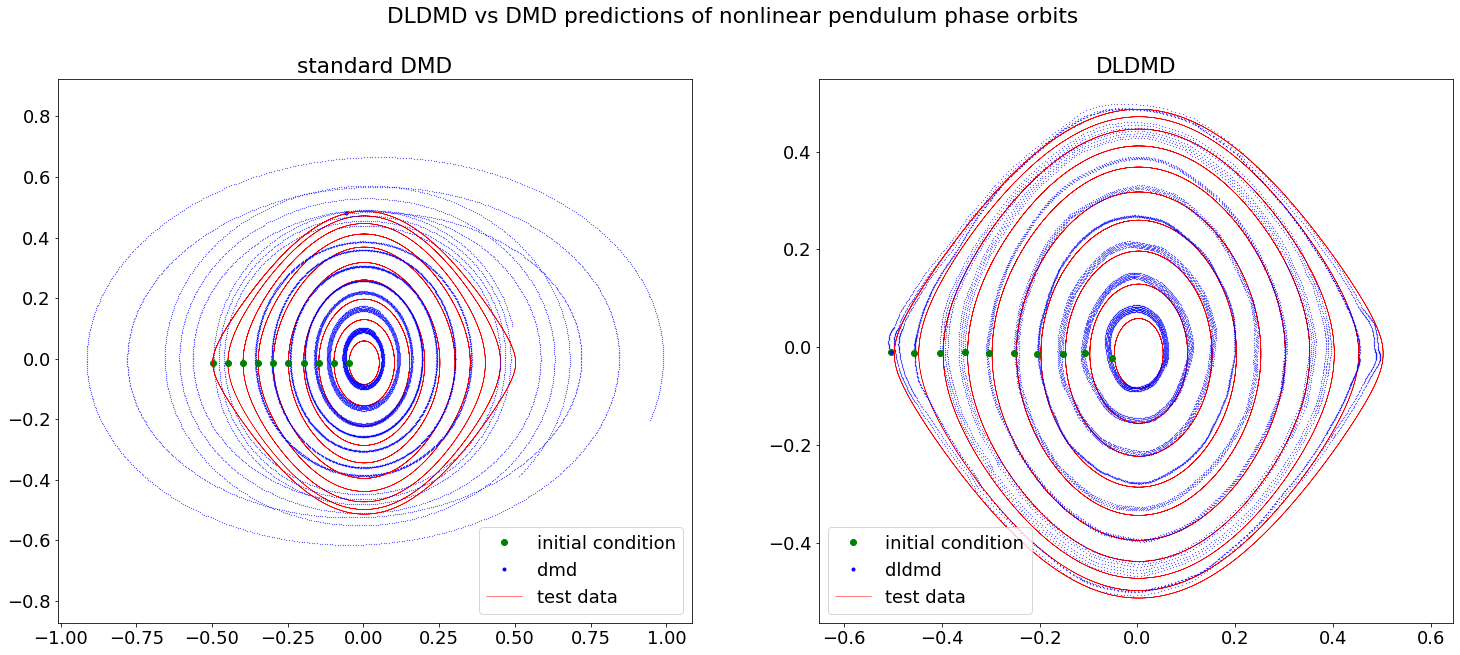

In [9]:
fig = plt.figure(3141, figsize=(25,10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
for ii in range(test_data.shape[0]):
    ax1.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'r-', lw=0.5)
    ax1.plot(x_dmd[ii, :, 0], x_dmd[ii, :, 1], 'b.', ms=0.5)
    ax2.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'r-', lw=0.5)
    ax2.plot(x_adv[ii, :, 0], x_adv[ii, :, 1], 'b.', ms=0.5)
ax1.plot(test_data[:, 0, 0], test_data[:, 0, 1], 'go', label='initial condition')
ax2.plot(x_adv[:, 0, 0], x_adv[:, 0, 1], 'go', label='initial condition')
ax1.plot(x_dmd[0, 0, 0], x_dmd[0, 0, 1], 'b.', label='dmd')
ax2.plot(x_adv[0, 0, 0], x_adv[0, 0, 1], 'b.', label='dldmd')
ax1.plot(test_data[0, :, 0], test_data[0, :, 1], 'r-', lw=0.5, label='test data')
ax2.plot(test_data[0, :, 0], test_data[0, :, 1], 'r-', lw=0.5, label='test data')
ax1.legend()
ax2.legend()
ax1.axis('equal')
ax2.axis('equal')
ax1.set_title('standard DMD')
ax2.set_title('DLDMD')
plt.suptitle("DLDMD vs DMD predictions of nonlinear pendulum phase orbits")
plt.show()

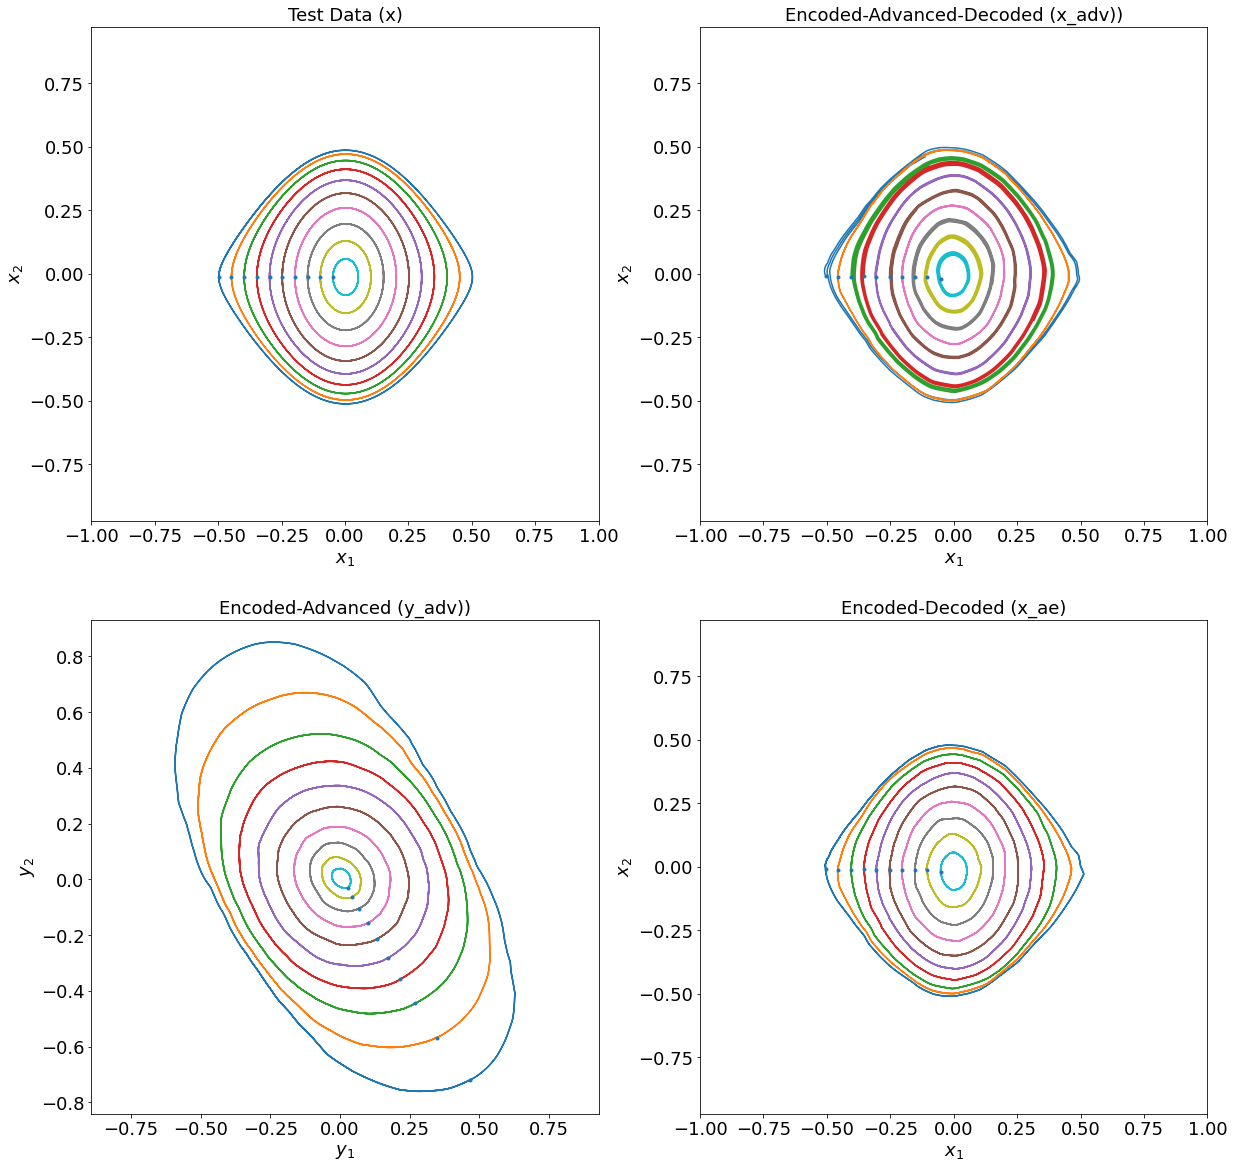

In [12]:
fig = plt.figure(1, figsize=(20,20))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
for ii in range(test_data.shape[0]):
    ax1.plot(test_data[ii, :, 0], test_data[ii, :, 1], '-')
    ax2.plot(x_adv[ii, :, 0], x_adv[ii, :, 1], '-')
    ax3.plot(y[ii, :, 0], y[ii, :, 1], '-')
    ax4.plot(x_ae[ii, :, 0], x_ae[ii, :, 1], '-')
ax1.plot(test_data[:, 0, 0], test_data[:, 0, 1], '.')
ax2.plot(x_adv[:, 0, 0], x_adv[:, 0, 1], '.')
ax3.plot(y_adv[:, 0, 0], y_adv[:, 0, 1], '.')
ax4.plot(x_ae[:, 0, 0], x_ae[:, 0, 1], '.')
ax1.axis('equal')
ax1.set_xlim([-1, 1])
ax1.set_ylim([-1, 1])
ax1.set_xlabel("$x_1$", fontsize=fontsize)
ax1.set_ylabel("$x_2$", fontsize=fontsize)
ax1.set_title("Test Data (x)", fontsize=fontsize)
ax2.axis('equal')
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
ax2.set_xlabel("$x_1$", fontsize=fontsize)
ax2.set_ylabel("$x_2$", fontsize=fontsize)
ax2.set_title("Encoded-Advanced-Decoded (x_adv))", fontsize=fontsize)
ax3.axis('equal')
ax3.set_xlabel("$y_1$", fontsize=fontsize)
ax3.set_ylabel("$y_2$", fontsize=fontsize)
ax3.set_title("Encoded-Advanced (y_adv))", fontsize=fontsize)
ax4.axis('equal')
ax4.set_xlim([-1, 1])
ax4.set_ylim([-1, 1])
ax4.set_xlabel("$x_1$", fontsize=fontsize)
ax4.set_ylabel("$x_2$", fontsize=fontsize)
ax4.set_title("Encoded-Decoded (x_ae)", fontsize=fontsize)

plt.show()

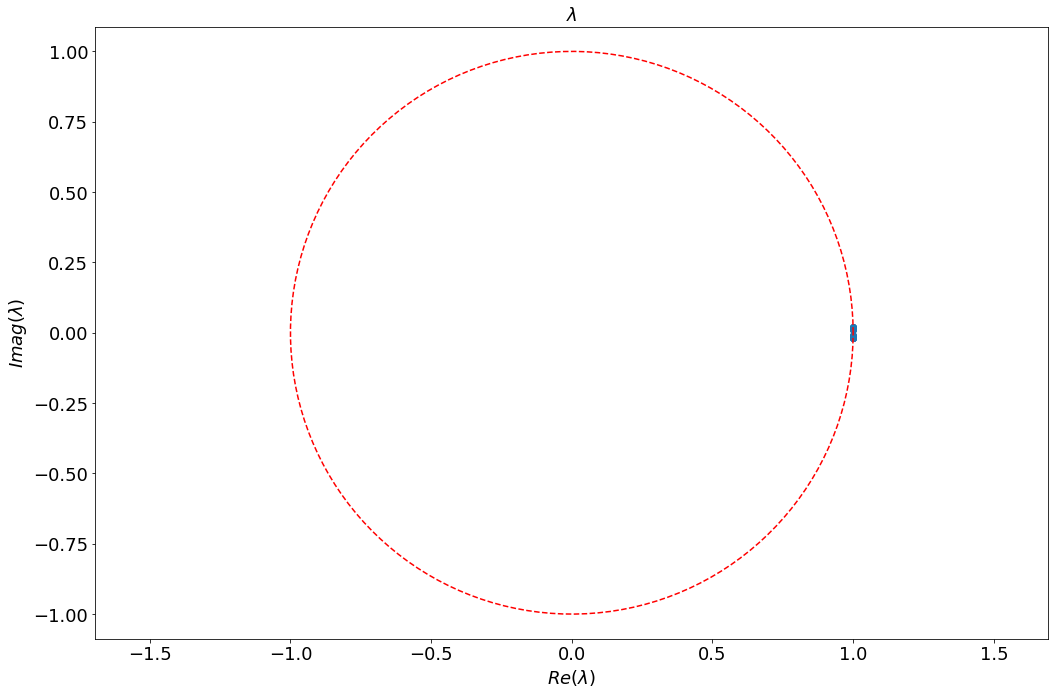

In [13]:
# Eigenvalues
angle = np.linspace(0, 2*np.pi, 150)
radius = 1.0
x = radius * np.cos(angle)
y = radius * np.sin(angle)
fig = plt.figure(123, figsize=figsize)
ax1 = plt.subplot(1, 1, 1)
s1 = ax1.scatter(np.real(Lam[:]), np.imag(Lam[:]))
ax1.plot(x, y, 'r--')
ax1.axis('equal')
ax1.set_xlabel("$Re(\lambda)$", fontsize=fontsize)
ax1.set_ylabel("$Imag(\lambda)$", fontsize=fontsize)
ax1.set_title("$\lambda$", fontsize=fontsize)
plt.tight_layout()
plt.show()